# *Multi Step Approach*

- Use the Task 1 labeled data to create a model to predict tumor presence or absence on axial T1wCE images
- The tumor slice predictor is then used on Task 2 data after converting the data to 128x128x128 volumes to account for orientation differences in the dicom data
- Positive tumor slices are used to create a tiled image
- The image is composed of 3 channels in order to use info from three scan types at once
- Finally, MGMT status is trained with the 3 channel, tumor positive tiles and predicted on the test set


## *Building on the prior work from:*

- "Load Task 1 Dataset & Comparison w/ Task 2 Dataset" by Darien Schettler  https://www.kaggle.com/dschettler8845/load-task-1-dataset-comparison-w-task-2-dataset which was used to create the data in '../input/task1-output/data'

- "Normalized Voxels: Align Planes and Crop" by yu4u  https://www.kaggle.com/ren4yu/normalized-voxels-align-planes-and-crop/data


This approach is new because the tiled approach flattens the 3D volume into a 2D array of images. Only the images with tumor are used and the RGB channels of the jpg images are used to store info from three different scan types.

This gets about as bad results as everything else :-) but it's a different way to look at the data. 



## Example of a Tiled image with one scan type in each of 3 channels

# 4x4 

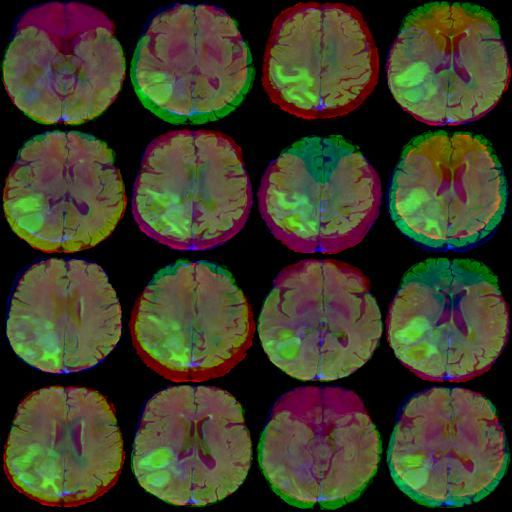

# 5x5

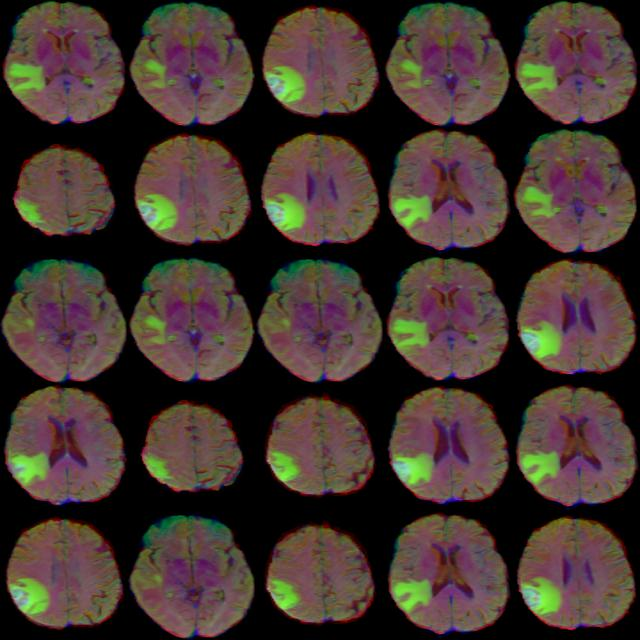

## **Imports**

In [ ]:
import sys
!{sys.executable} -m pip install ../input/pydicomfastaihelper/torch-1.9.0-cp37-cp37m-manylinux1_x86_64.whl -q
!{sys.executable} -m pip install ../input/pydicomfastaihelper/torchvision-0.10.0-cp37-cp37m-manylinux1_x86_64.whl -q
!{sys.executable} -m pip install ../input/pydicomfastaihelper/fastcore-1.3.26-py3-none-any.whl -q
!{sys.executable} -m pip install ../input/pydicomfastaihelper/fastai-2.5.2-py3-none-any.whl -q

In [ ]:
# from Awsaf pydicom_conda_helper
!conda install '/kaggle/input/pydicomfastaihelper/libjpeg-turbo-2.1.0-h7f98852_0.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicomfastaihelper/libgcc-ng-9.3.0-h2828fa1_19.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicomfastaihelper/gdcm-2.8.9-py37h500ead1_1.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicomfastaihelper/conda-4.10.1-py37h89c1867_0.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicomfastaihelper/certifi-2020.12.5-py37h89c1867_1.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicomfastaihelper/openssl-1.1.1k-h7f98852_0.tar.bz2' -c conda-forge -y

In [ ]:
import os
import PIL
import cv2
import tarfile
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import nibabel as nib
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from tqdm.notebook import tqdm
import shutil

import random
random.seed(42)

from pathlib import Path

## Identify Slices with Tumor Labels

- Label 1 shows necrotic and non-enhancing tumor core and label 4 shows contrast enhancing tumor. We'll combine those and call those slices tumor positive. Other slices are negative.

- Only one volume is used for tumor slice prediction - T1wCE. The contrast enhanced study is used to take advantage of label 4.

- The volumes are large, so we will only use every third slice. There are also many slices with minimal or no brain, only slices with more than the minimum number of non-zero pixels will be included.

- Create a csv for training labels identifying slices with and without tumor.

- Save chosen slices to jpg for training.

In [ ]:
def normalize_contrast(voxel):
    if voxel.sum() == 0:
        return voxel
    voxel = voxel - np.min(voxel)
    voxel = voxel / np.max(voxel)
    voxel = (voxel * 255).astype(np.uint8)
    return voxel

def load_nii(study_id, scan_type):
    fn = f'{data_folder}/BraTS2021_{study_id}/BraTS2021_{study_id}_{scan_type}.nii.gz'
    if Path(fn).is_file():
        nii = nib.load(fn).get_fdata()
        nii = normalize_contrast(nii)
        return nii
    else:
        print(fn)
        return None

In [ ]:
min_brain = 1000
data_folder = '../input/task1-output/data'

if not os.path.isdir("/kaggle/working/slices"):
    os.makedirs("/kaggle/working/slices", exist_ok=True)
    
collect = []
case_dirs = Path(data_folder).iterdir()
case_dirs = [_ for _ in case_dirs]

for case in tqdm(case_dirs, total =len(case_dirs)):
    seg_files = [_ for _ in case.glob("*_seg.nii.gz")]
    
    if len(seg_files) > 0:
        seg = nib.load(seg_files[0]).get_fdata()
        #Labels 1 and 4 are tumor labels
        labels = [1* (((seg[:,:,o] == 1).sum() + (seg[:,:,o] == 4).sum()) > 0) for o in range(seg.shape[-1])]

        study_id= str(case).split('_')[1]
        nii = load_nii(study_id, 't1ce')

        for i in range(0,nii.shape[-1],3):
            if (nii[:,:,i] > 0).sum() > min_brain:
                save_fn = f'slices/{study_id}_{i}.jpg'
                collect.append({'filename':save_fn, 'study_id': study_id, 'slice': i, 'has_tumor': labels[i]})
                #Rotate
                rot = np.rot90(nii[:,:,i],3)
                img = Image.fromarray(rot)
                img = img.convert("L")
                img.save(save_fn)
    

collect = pd.DataFrame(collect)
collect.to_csv('./tumor_slices_brats_axial_thirds.csv',index=False)
collect.head()

In [ ]:
collect.has_tumor.value_counts()

## Train on Tumor Slices from Part 1

In [ ]:
#!pip install fastai --upgrade -q

In [ ]:
models_data_root = Path('models/')
models_data_root.mkdir(parents=True, exist_ok=True)

cwd = '/kaggle/working/'

In [ ]:
from fastai.vision.all import *

bs = 64

df = collect[['filename', 'has_tumor']]

dls = ImageDataLoaders.from_df(df, path=cwd, bs=bs, item_tfms=Resize(224), batch_tfms=[ *aug_transforms()])
dls.vocab

In [ ]:
learn = cnn_learner(dls, resnet50,loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy])
learn.fine_tune(20)

In [ ]:
tumor_slice_model_name = Path.joinpath(models_data_root, 'tumor_slice.pkl')
learn.export(tumor_slice_model_name)

In [ ]:
#remove training folder
shutil.rmtree('slices') 

## Voxel class

In [ ]:
# Voxel from dicom from "Normalized Voxels: Align Planes and Crop" by yu4u
    # https://www.kaggle.com/ren4yu/normalized-voxels-align-planes-and-crop/data
    # https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
    # https://www.kaggle.com/davidbroberts/determining-mr-image-planes
    
class Voxel:
    def __init__(self,study_id, dicom_folder, save_data_folder, icon_size):

        self.study_id=study_id
        self.dicom_folder=dicom_folder
        self.save_data_folder=save_data_folder
        self.icon_size=icon_size

    def get_voxel_data_root(self):
        return Path(self.save_data_folder).joinpath(f'voxels_{self.icon_size}')

    def get_voxel_prepared(self):
        #/kaggle/working/data/voxels_128/{study_id}/{scan_type}.npy
        fn = f'{self.get_voxel_data_root()}/{self.study_id}/{Path(self.dicom_folder).parts[-1]}.npy'
        if os.path.isfile(fn) == False:
            self.create_and_save_voxels()
        voxel = np.load(fn)
        return voxel

    def get_image_plane(self, data):
        x1, y1, _, x2, y2, _ = [round(j) for j in data.ImageOrientationPatient]
        cords = [x1, y1, x2, y2]

        if cords == [1, 0, 0, 0]:
            return 'Coronal'
        elif cords == [1, 0, 0, 1]:
            return 'Axial'
        elif cords == [0, 1, 0, 0]:
            return 'Sagittal'
        else:
            return 'Unknown'
        
    def get_dicom_paths(self):
        dicom_paths = sorted(self.dicom_folder.glob("*.dcm"), key=lambda x: int(x.stem.split("-")[-1]))
        return dicom_paths

    def get_voxel(self):
        imgs = []
        positions = []
        dcm_paths = self.get_dicom_paths()
        for dcm_path in dcm_paths:
            img = pydicom.dcmread(str(dcm_path))
            imgs.append(img.pixel_array)
            positions.append(img.ImagePositionPatient)
            
        plane = self.get_image_plane(img)
        voxel = np.stack(imgs)
        
        # reorder planes if needed and rotate voxel
        if plane == "Coronal":
            if positions[0][1] < positions[-1][1]:
                voxel = voxel[::-1]
                #print(f"{study_id} {scan_type} {plane} reordered")
            voxel = voxel.transpose((1, 0, 2))
        elif plane == "Sagittal":
            if positions[0][0] < positions[-1][0]:
                voxel = voxel[::-1]
                #print(f"{study_id} {scan_type} {plane} reordered")
            voxel = voxel.transpose((1, 2, 0))
            voxel = np.rot90(voxel, 2, axes=(1, 2))
        elif plane == "Axial":
            if positions[0][2] > positions[-1][2]:
                voxel = voxel[::-1]
                #print(f"{study_id} {scan_type} {plane} reordered")
            voxel = np.rot90(voxel, 2)
        else:
            if positions[0][2] > positions[-1][2]:
                voxel = voxel[::-1]
                #print(f"{study_id} {scan_type} {plane} reordered")
            voxel = np.rot90(voxel, 2)
            #raise ValueError(f"Unknown plane {plane}")
        return voxel, plane

    def normalize_contrast(self, voxel):
        if voxel.sum() == 0:
            return voxel
        voxel = voxel - np.min(voxel)
        voxel = voxel / np.max(voxel)
        voxel = (voxel * 255).astype(np.uint8)
        return voxel

    def crop_voxel(self, voxel):
        if voxel.sum() == 0:
            return voxel
        keep = (voxel.mean(axis=(0, 1)) > 0)
        voxel = voxel[:, :, keep]
        keep = (voxel.mean(axis=(0, 2)) > 0)
        voxel = voxel[:, keep]
        keep = (voxel.mean(axis=(1, 2)) > 0)
        voxel = voxel[keep]
        return voxel

    def resize_voxel(self, voxel):
        sz = int(self.icon_size)
        output = np.zeros((sz, sz, sz), dtype=np.uint8)

        if np.argmax(voxel.shape) == 0:
            for i, s in enumerate(np.linspace(0, voxel.shape[0] - 1, sz)):
                output[i] = cv2.resize(voxel[int(s)], (sz, sz))
        elif np.argmax(voxel.shape) == 1:
            for i, s in enumerate(np.linspace(0, voxel.shape[1] - 1, sz)):
                output[:, i] = cv2.resize(voxel[:, int(s)], (sz, sz))
        elif np.argmax(voxel.shape) == 2:
            for i, s in enumerate(np.linspace(0, voxel.shape[2] - 1, sz)):
                output[:, :, i] = cv2.resize(voxel[:, :, int(s)], (sz, sz))

        return output

    def create_voxel(self):
        voxel, _ = self.get_voxel()
        voxel = self.normalize_contrast(voxel)
        voxel = self.crop_voxel(voxel)
        voxel = self.resize_voxel(voxel)
        return voxel

    def create_and_save_voxels(self):
        p = self.get_voxel_data_root().joinpath(self.study_id)
        p.mkdir(parents=True, exist_ok=True)
        #create and save voxels
        fn = f'{self.get_voxel_data_root()}/{self.study_id}/{Path(self.dicom_folder).parts[-1]}.npy'
        
        if Path(fn).is_file() == False:
            voxel = self.create_voxel()
            np.save(fn, voxel)

In [ ]:
# specific function to get ids
def get_study_ids(dicom_data_root):
    study_ids = dicom_data_root.iterdir()
    return [o.name for o in study_ids]


## Create voxels for T1w, FLAIR, T1wCE

In [ ]:
scan_types= ['T1w','FLAIR','T1wCE']
# Size of one image/tile in tiles
icon_size=128
# Tiles is an n x n array but can be made larger
icons_per_side=5

orientation='axial'
#dataset = 'train'

train_dicom_data_root = Path(f"../input/rsna-miccai-brain-tumor-radiogenomic-classification/train")
test_dicom_data_root = Path(f"../input/rsna-miccai-brain-tumor-radiogenomic-classification/test")

save_data_folder=Path('data/')
save_data_folder.mkdir(parents=True, exist_ok=True)

slices_data_root= Path('slices/')
slices_data_root.mkdir(parents=True, exist_ok=True)

voxel_data_root = Path(save_data_folder).joinpath(f'voxels_{icon_size}')
voxel_data_root.mkdir(parents=True, exist_ok=True)

tiles_data_root = Path('tiles/')
tiles_data_root.mkdir(parents=True, exist_ok=True)

In [ ]:
def create_voxels_for_dataset(dicom_data_root):
    study_ids = get_study_ids(dicom_data_root)
    print('Creating voxels - ', scan_types)
    for study_id in tqdm(study_ids):
        for scan_type in scan_types:
            #create voxels
            dicom_folder = Path(f'{dicom_data_root}/{study_id}/{scan_type}')
            if dicom_folder.is_dir():
                v = Voxel(study_id, dicom_folder, save_data_folder, icon_size)

                p = v.get_voxel_data_root().joinpath(study_id)
                p.mkdir(parents=True, exist_ok=True)
                    #create and save voxels
                fn = f'{p}/{scan_type}.npy'
                #print(fn)
                if Path(fn).is_file() == False:
                    voxel = v.create_voxel()
                    np.save(fn, voxel)

In [ ]:
create_voxels_for_dataset(train_dicom_data_root)

## Use model to evaluate training slices on Task 2 - T1wCE

In [ ]:
# Create slices
def create_slices(dicom_folder):
    #Load voxel
    if dicom_folder.is_dir():
        study_id = dicom_folder.parts[-2]
        # Load T1wCE voxel
        v = Voxel(study_id, dicom_folder, save_data_folder, icon_size)
        voxel = v.get_voxel_prepared()
        
        # Create directory for study_id
        if not os.path.isdir(f"/kaggle/working/slices/{study_id}"):
            os.makedirs(f"/kaggle/working/slices/{study_id}", exist_ok=True)
    
        # Convert to jpg
        step = 3
        if voxel.shape[0] < 100:
            step = 2
        for i in range(0,voxel.shape[0],step):
            if (voxel[i] > 0).sum() > min_brain:
                im = Image.fromarray(np.array(np.flipud(voxel[i])))
                save_fn = f'/kaggle/working/slices/{study_id}/{study_id}_{i}.jpg'
                im.save(save_fn)
                
def create_slices_for_dataset(dicom_data_root, scan_type = 'T1wCE'):
    study_ids = get_study_ids(dicom_data_root)
    for study_id in tqdm(study_ids):
        dicom_folder = Path(f'{dicom_data_root}/{study_id}/{scan_type}')
        create_slices(dicom_folder)

In [ ]:
create_slices_for_dataset(train_dicom_data_root)

In [ ]:
# Predict tumor slices
#load model
learn = load_learner(tumor_slice_model_name)

def predict(image_paths):
    dl = learn.dls.test_dl(image_paths)
    preds, _ = learn.get_preds(dl=dl)
    class_idxs = preds.argmax(dim=1)
    predictions =  [learn.dls.vocab[c] for c in class_idxs]
    confidence = preds.max(dim=1)[0]
    return predictions, confidence

def predict_dataset(dicom_data_root, scan_type = 'T1wCE'):
    collect = []
    study_ids = get_study_ids(dicom_data_root)

    for idx, study_id in enumerate(study_ids):
        if idx%250==0 and idx > 0:
            print(idx)
            temp = pd.DataFrame(collect)
            temp.to_csv(f'predict_slices_{dicom_data_root.parts[-1]}_{idx}.csv', index=False)

        #get image_paths
        study_folder = Path(f"/kaggle/working/slices/{study_id}")
        if study_folder.is_dir():
            image_paths = study_folder.glob('*.jpg')
            image_paths = [_ for _ in image_paths]
            #predict
            predictions, confidence = predict(image_paths)
            tmp = []
            for i,image_path in enumerate(image_paths):
                slice_number = image_path.stem.split('_')[-1]
                tmp.append({'filename':image_path,'scan_type':scan_type, 'study_id': study_id, 'slice': int(slice_number), 'has_tumor': predictions[i], 'confidence':float(confidence[i])})

            collect.extend(tmp)
    if len(collect) == 0:
        print("No predictions")
        return pd.DataFrame(columns=['filename','scan_type', 'study_id', 'slice', 'has_tumor', 'confidence'])
    else:
        return pd.DataFrame(collect)

In [ ]:
df = predict_dataset(train_dicom_data_root)
df.to_csv(f'predict_slices_train.csv', index=False)

In [ ]:
df.head()

# Tiles

## Use positive predictions to create tiles

In [ ]:
def get_tumor_slices(study_id, df):
    studydf = df[df.study_id == study_id].sort_values('confidence',ascending=False).head(icons_per_side**2)
    if studydf.shape[0] == 0:
        #each voxel has 128 slices
        return list(range(15,icon_size-15))
    return studydf.slice.unique()

def get_idxs(study_id, df):
    slices = get_tumor_slices(study_id, df)
    if len(slices) >= icons_per_side**2:
        return random.sample(list(slices), icons_per_side**2)
    else:
        #fill in tiles with duplicates
        return random.choices(slices, k=icons_per_side**2)

In [ ]:
class Tiles:
    def __init__(self,study_id, input_array, tiles_data_root, icon_size, icons_per_side):
   
        self.study_id=study_id
        self.input_array=input_array
        self.tiles_data_root=tiles_data_root
        self.icon_size=icon_size
        self.icons_per_side=icons_per_side
      
   
    def create_tile_channel(self, i):
        inputs = self.input_array[i]
        tile = Image.new("RGB", (self.icons_per_side * self.icon_size, self.icons_per_side * self.icon_size))
        for index, im in enumerate(inputs):
            img = Image.fromarray(im)
            y = index // self.icons_per_side * self.icon_size
            x = index % self.icons_per_side * self.icon_size
            w, h = self.icon_size, self.icon_size
            box = (int(x), int(y), int(x + w), int(y + h))
            tile.paste(img, box)
        return tile.split()[0]

    def create_tiles(self):
        channels = []
        for i in range(len(self.input_array)): 
            if len(self.input_array) == 0:
                return None
            channel = self.create_tile_channel(i)
            channels.append(channel)
        if len(channels) >=3:
            return Image.merge('RGB',channels[:3])
        elif len(channels) == 2:
            return Image.merge('RGB',(channels[0],channels[1],channels[0]))
        elif len(channels) ==1 :
            return Image.merge('RGB',(channels[0],channels[0],channels[0]))

    def get_save_filename(self):
        save_dir = self.tiles_data_root
        save_dir.mkdir(parents=True, exist_ok=True)
        fn = Path(save_dir).joinpath(f'{self.study_id}.jpg')
        return str(fn)

    def create_and_save_tiles(self):
        img = self.create_tiles()
        if img is not None:
            fn = self.get_save_filename()
            img.save(fn)

In [ ]:
def create_tile(df, study_id):
    input_array = []
    #use same idxs for all 3 channels, use positive slices
    idxs = get_idxs(study_id, df[(df.study_id == study_id) & (df.has_tumor == 1)])
    #create 3 channel input array from each of the 3 scan_types  ['T1w','FLAIR','T1wCE']
    for scan_type in scan_types:
        #get voxel
        fn = f'{voxel_data_root}/{study_id}/{scan_type}.npy'
        if Path(fn).is_file():
            voxel = np.load(fn)
            #axial
            voxel = np.array([np.flipud(voxel[i]) for i in range(voxel.shape[0])])
            inputs = [voxel[idx] for idx in idxs]
            input_array.append(inputs)
        else:
            print(fn)
    #create tile
    tile = Tiles(study_id, input_array, tiles_data_root, icon_size, icons_per_side)
    tile.create_and_save_tiles()
    


In [ ]:
# not using Pool
def create_tiles_for_dataset(df, dicom_data_root):
    study_ids = get_study_ids(dicom_data_root)
    for study_id in tqdm(study_ids):
        create_tile(df, study_id)

create_tiles_for_dataset(df, train_dicom_data_root)

In [ ]:
#Using Pool
# import multiprocessing as mp
# pool = mp.Pool(mp.cpu_count())

# study_ids = get_study_ids(train_dicom_data_root)

# # Step 1: Init multiprocessing.Pool()
# pool = mp.Pool(mp.cpu_count())

# # Step 2: `pool.apply` the `howmany_within_range()`
# results = pool.map(create_tile, [study_id for study_id in study_ids])

# # Step 3: Don't forget to close
# pool.close()

## Train MGMT on Tiles

In [ ]:
# Load Competition Training Dataframe
a = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv", dtype={'BraTS21ID': str, 'MGMT_value': int})
a = a.rename({'BraTS21ID':'study_id'}, axis=1)

remove = ['00109', '00123', '00709']
a = a[~a.study_id.isin(remove)]

a['filename'] = [f'{tiles_data_root}/{study_id}.jpg' for _,study_id in a.study_id.iteritems()]
a =  a[['filename', 'MGMT_value']]
a.head()

In [ ]:
bs = 32

dls = ImageDataLoaders.from_df(a, path=cwd, bs=bs, item_tfms=Resize(224), batch_tfms=[ *aug_transforms(mult=1.0, do_flip=True, flip_vert=False, max_rotate=10.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.05, p_affine=0.1, p_lighting=0.75, xtra_tfms=None, size=None, mode='bilinear', pad_mode='reflection', align_corners=True, batch=False, min_scale=1.0)])
dls.vocab

In [ ]:
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy, RocAucBinary()])
learn.fine_tune(50)

In [ ]:
mgmt_model_name = Path.joinpath(models_data_root, 'miccai.pkl')
learn.export(mgmt_model_name)

In [ ]:
#cleanup voxels, slices, tiles for training data
for dir in ['slices','data','tiles']:
    path = os.path.join(cwd, dir)
    # removing directory
    if Path(path).is_dir():
        shutil.rmtree(path) 

# Prepare Test set

## Create Test set Tiles

In [ ]:
#reset directories
save_data_folder=Path('data/')
save_data_folder.mkdir(parents=True, exist_ok=True)

slices_data_root= Path('slices/')
slices_data_root.mkdir(parents=True, exist_ok=True)

voxel_data_root = Path(save_data_folder).joinpath(f'voxels_{icon_size}')
voxel_data_root.mkdir(parents=True, exist_ok=True)

tiles_data_root = Path('tiles/')
tiles_data_root.mkdir(parents=True, exist_ok=True)

## Dicom -> Voxels -> Slices -> Tiles

In [ ]:
#create voxels
print('Creating voxels...')
create_voxels_for_dataset(test_dicom_data_root)
#create slices
print('Creating slices...')
create_slices_for_dataset(test_dicom_data_root)
#predict on slices to get those with tumor
print('Evaluating slices...')
learn = load_learner(tumor_slice_model_name)
df = predict_dataset(test_dicom_data_root)
#create tiles
print('Creating tiles...')
create_tiles_for_dataset(df, test_dicom_data_root)
print('Done')

## Predict MGMT_value on Test set Tiles

In [ ]:
learn = load_learner(mgmt_model_name)

image_paths = tiles_data_root.glob('*.jpg')
image_paths = [_ for _ in image_paths]

dl = learn.dls.test_dl(image_paths)
preds, _ = learn.get_preds(dl=dl)
class_idxs = preds.argmax(dim=1)
predictions =  [learn.dls.vocab[c] for c in class_idxs]
confidence = preds.max(dim=1)[0]

final = []
for i,image_path in enumerate(image_paths):
    study_id = image_path.stem
    final.append({'study_id': study_id, 'prediction': predictions[i], 'confidence':confidence[i]})

final = pd.DataFrame(final)
final.head()

In [ ]:
final.prediction.value_counts()

### Cleanup

In [ ]:
#cleanup voxels, slices, tiles
dr = '/kaggle/working'
# path
for dir in ['slices','data','tiles']:
    path = os.path.join(dr, dir)
    # removing directory
    if Path(path).is_dir():
        shutil.rmtree(path) 

## Submission file

In [ ]:
final = final[['study_id', 'prediction']]
final.columns = ['BraTS21ID','MGMT_value']
final.to_csv('submission.csv', index=False)